In [20]:
%load_ext autoreload
%autoreload 2

import __confing
__confing.change_to_root_folder()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current directory: c:\Users\Leo\OneDrive\Escritorio\Nueva carpeta\hospitalization-prediction


In [21]:
try:
    __confing.execute_notebook('notebooks/0_data_extract.ipynb')
except:
    pass

In [22]:
import pandas as pd
import numpy as np

from src.feature_selection import fast_fill

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, recall_score, classification_report, accuracy_score ,confusion_matrix
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
n='a'
df=pd.read_csv(r'data\custom\all_waves.csv')
df = df.loc[df['paagey'] >= 50]
target=f'p{n}hosp1y'

In [24]:
df=pd.read_csv(r'data\custom\all_waves.csv')
df = df.loc[df['paagey'] >= 50]
target='pahosp1y'

selected=[
    'pahosp1y',     'pahipe_m',     'padadage',     'pamomage', 
    'pahibpe',      'palunge_m',    'pacholst',     'pagrossaa', 
    'paosleep',     'pafallinj',    'pacancre',     'paswell', 
    'pachair',      'parafaany',    'pawheeze',     'paagey', 
    'paarthre',     'padiabe',      'parjudg',      'paweight', 
    'paclims',      'pastroke',     'pabathehlp',   'pasmokev', 
    'pahearaid',    'pameds',       'paheight',     'paglasses', 
    'paeat',        'papaina',      'pagender',     'padrinkb'
]
print(f"There are {len(selected)} features selected")

There are 32 features selected


In [25]:
df3 = df.where(df['cpindex'] <= 107.69).dropna(subset=['cpindex']) # 107.69

selected = list(set(selected))

df_s = df3.dropna(subset=[target]) 
df_s = df_s[selected].copy()

porcentaje_nulos = df_s.isnull().sum(axis=1) / len(df.columns)
df_s = df_s[(df_s[target] != 0) | (porcentaje_nulos <= 0.5)]

y = df_s[target]
X = df_s.drop(target,axis=1)

X = fast_fill(X)
X=X.sort_index(axis=1)

In [26]:
scaler = StandardScaler()
X=scaler.fit_transform(X)

transformer = PowerTransformer(method='yeo-johnson')
X=transformer.fit_transform(X)
pass

In [27]:
zeros=y.value_counts()[0]
unos=y.value_counts()[1]

In [28]:
params={
        'max_depth': 8, 
        'subsample': 0.759545947005226,
        'colsample_bytree': 0.9075616505206274, 
        'eta': 0.05568753700048324, 
        'min_child_weight': 5, 
        'learning_rate': 0.0999908981133205, 
        'n_estimators': 560,
        'scale_pos_weight': (zeros/unos)-2.5, # 
        'n_jobs':-1
}

model = XGBClassifier(**params)

In [29]:
y_test_all = []
y_pred_all = []
y_pred_prov_all = []

kf = KFold(n_splits=7)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    
    y_test_all.extend(y_test)
    y_pred_all.extend(model.predict(X_test))
    y_pred_prov_all.extend(model.predict_proba(X_test))

In [ ]:
auc = roc_auc_score(y_test_all,  np.array(y_pred_prov_all)[:,1])

recall = recall_score(y_test_all, y_pred_all)

report = classification_report(y_test_all, y_pred_all)

accuracy = accuracy_score(y_test_all, y_pred_all)

print("AUC:", auc)
print("Accuracy:", accuracy)
print("Recall:", recall)

print("\nClassification Report:")
print(report)

AUC: 0.937910056104865
Accuracy: 0.9617598624287734
Recall: 0.8072553045859001

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     61314
         1.0       0.83      0.81      0.82      7305

    accuracy                           0.96     68619
   macro avg       0.90      0.89      0.90     68619
weighted avg       0.96      0.96      0.96     68619



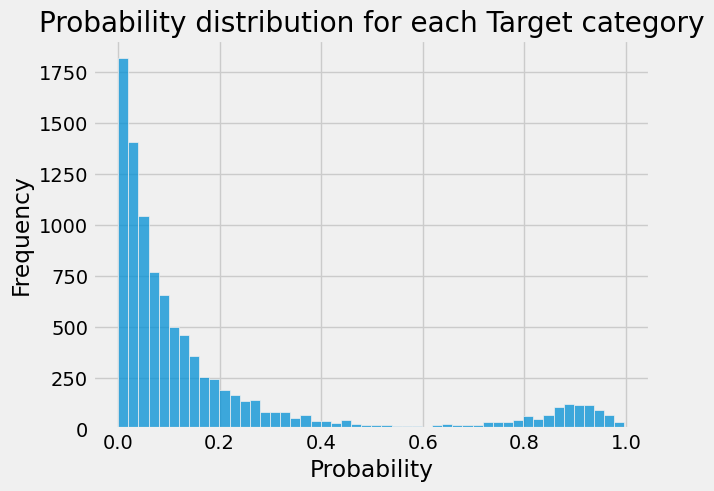

In [ ]:
with plt.style.context('fivethirtyeight'):
    sns.histplot(model.predict_proba(X_test)[:,1], bins=50)
    plt.title("Probability distribution for each Target category")
    plt.xlabel("Probability")
    plt.ylabel("Frequency")
    plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt

# Calcular el AUC
auc = roc_auc_score(y_test_all,  np.array(y_pred_prov_all)[:,1])

# Crear el gráfico ROC
fpr, tpr, thresholds = roc_curve(y_test_all,  np.array(y_pred_prov_all)[:,1])

# Crear la figura y el eje
fig, ax = plt.subplots()

# Graficar la curva ROC
sns.lineplot(x=fpr, y=tpr, ax=ax)

# Configurar los ejes y la etiqueta
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate', title='Receiver Operating Characteristic')

# Mostrar la leyenda
ax.legend([f'AUC = {auc:.4f}'])

# Mostrar el gráfico
plt.show()